In [1]:
from likelihood import discrete_loglikelihood
from SS_DM_Prior import SS_DM_dist_setup
from prior import discrete_logprior
import numpy as np
from scipy.special import logsumexp
from scipy import interpolate
from matplotlib import pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from time import perf_counter

# disc_prior = discrete_logprior(logfunction=lambda x, y, z, w: np.log(np.abs(y+x-w)*z), name='test',
#                                axes=(np.linspace(0,1,101), np.linspace(0,1,51),), axes_names=['energy', 'offset'],
#                                default_hyperparameter_values=(1,1), hyperparameter_names=['h1', 'h2'])

/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
start = perf_counter()
start

3.150506583

In [3]:
# disc_prior

In [4]:
# plt.figure()
# plt.hist2d(*disc_prior.sample(100000), bins=(50,50))
# plt.show()

In [5]:
numsamples = int(1e3)
signalfraction = 0.8
truelogmass = 0.5

nsig = int(round(signalfraction*numsamples))
nbkg = int(round((1-signalfraction)*numsamples))

signalfraction = nsig/(nsig+nbkg)

# Prior Sampling

## Dark Matter Prior

In [6]:
darkSUSY_to_Gammapy_converter = {
    "nuenue":"nu_e",
    "e+e-": "e",
    "numunumu":"nu_mu",
    "mu+mu-":"mu",
    'nutaunutau':"nu_tau",
    "tau+tau-":"tau",
    "cc": "c",
    "bb": "b",
    "tt": "t",
    "W+W-": "W",
    "ZZ": "Z",
    "gg": "g",
    "gammagamma": "gamma",
    "HH": "h",
}

darkSUSY_BFs_cleaned = pd.read_csv('BFCalc/darkSUSY_BFs/darkSUSY_BFs_cleaned.csv', delimiter=' ')

darkSUSY_massvalues = darkSUSY_BFs_cleaned.iloc[:,1]/1e3

darkSUSY_lambdavalues = darkSUSY_BFs_cleaned.iloc[:,2]

channelfuncdictionary = {}

modulefolderpath = 'BFCalc'
log10xvals = np.load(modulefolderpath+f"/griddata/log10xvals_massenergy_diffflux_grid.npy")
massvalues = np.load(modulefolderpath+f"/griddata/massvals_massenergy_diffflux_grid.npy")

for darkSUSYchannel in list(darkSUSY_to_Gammapy_converter.keys()):
    gammapychannel = darkSUSY_to_Gammapy_converter[darkSUSYchannel]
    
    tempspectragrid = np.load(modulefolderpath+f"/griddata/channel={gammapychannel}_massenergy_diffflux_grid.npy")
    
    channelfuncdictionary[darkSUSYchannel] = interpolate.RegularGridInterpolator((np.log10(massvalues/1e3), log10xvals), np.array(tempspectragrid), 
                                                                                 method='linear', bounds_error=False, fill_value=1e-3000)



partial_sigmav_interpolator_dictionary = {channel: interpolate.LinearNDInterpolator((darkSUSY_massvalues, darkSUSY_lambdavalues),darkSUSY_BFs_cleaned.iloc[:,idx+3]) for idx, channel in enumerate(list(darkSUSY_to_Gammapy_converter.keys()))}



def nontrivial_coupling(logmass, logenergy, coupling=0.1, partial_sigmav_interpolator_dictionary=partial_sigmav_interpolator_dictionary, channelfuncdictionary=channelfuncdictionary ):
    
    
    logspectra = -np.inf
    for channel in channelfuncdictionary.keys():
        logspectra = np.logaddexp(logspectra, np.log(partial_sigmav_interpolator_dictionary[channel](10**logmass, coupling)*channelfuncdictionary[channel]((logmass, logenergy-logmass))))
    
    
    return logspectra
        

In [7]:
from utils3d import longitudeaxistrue, latitudeaxistrue, log10eaxistrue


logDMpriorfunc = SS_DM_dist_setup(nontrivial_coupling, longitudeaxistrue, latitudeaxistrue)

In [8]:
logenergy_true_logjacob = np.meshgrid(np.log(10**log10eaxistrue), longitudeaxistrue, latitudeaxistrue, indexing='ij')[0]

In [9]:
DM_prior = discrete_logprior(logfunction=logDMpriorfunc, name='Scalar Singlet Dark Matter Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), axes_names=['energy', 'lon', 'lat'],
                               default_hyperparameter_values=(truelogmass,), hyperparameter_names=['mass'], logjacob=logenergy_true_logjacob)
DM_prior

(0.5,)


discrete log prior class
----------------------------
name = Scalar Singlet Dark Matter Prior
logfunction type is <function SS_DM_dist_setup.<locals>.DM_signal_dist at 0x7f9cb3f548b0>
input units of None
over axes ['energy', 'lon', 'lat']
with hyperparameter(s) ['mass']

In [10]:
sig_samples = DM_prior.sample(nsig)

In [11]:
sigpriorvalues = np.exp(logsumexp(DM_prior((*np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij'),), (truelogmass,))+logenergy_true_logjacob, axis=(1,2)))

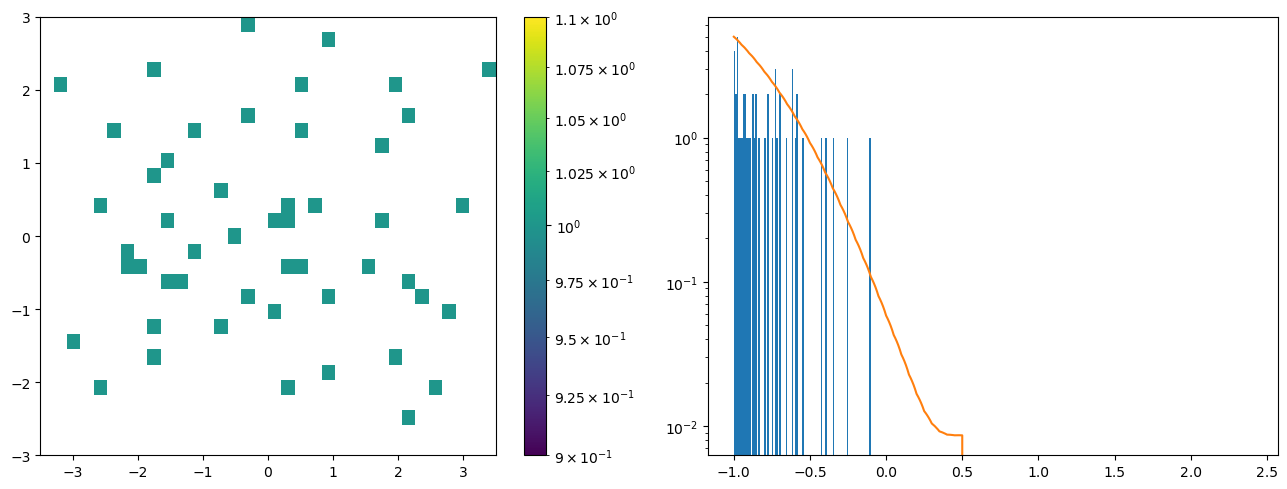

In [12]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.hist2d(sig_samples[1,:], sig_samples[2,:], bins=(longitudeaxistrue, latitudeaxistrue), norm=LogNorm())
plt.colorbar()

plt.subplot(1,2,2)
sigtruehistvals = plt.hist(sig_samples[0,:], bins=log10eaxistrue,)
plt.plot(log10eaxistrue, np.max(sigtruehistvals[0])*sigpriorvalues/np.max(sigpriorvalues))
plt.yscale('log')

plt.tight_layout()

## Background Prior

In [13]:
astrophysicalbackground = np.load("unnormalised_astrophysicalbackground.npy")
from utils3d import bkgdist

nuisancemesh = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')

unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(bkgdist(*nuisancemesh)),np.log(astrophysicalbackground))


logbkgfunc_annoying = interpolate.RegularGridInterpolator((log10eaxistrue, longitudeaxistrue, latitudeaxistrue), np.exp(unnormed_logbkgpriorvalues))
logbkgfunc = lambda logenergy, longitude, latitude: np.log(logbkgfunc_annoying((logenergy, longitude, latitude)))


bkg_prior = discrete_logprior(logfunction=logbkgfunc, name='Background Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), 
                               axes_names=['energy', 'lon', 'lat'], logjacob=logenergy_true_logjacob)

In [14]:
bkg_prior((0.0,0.0,0.0))

3.3067634676689934

In [15]:

if nbkg>0:
    bkg_samples = bkg_prior.sample(nbkg)
else:
    bkg_samples = []

bkg_samples

array([[-0.46      , -0.84      , -0.33      , -0.92      , -0.77      ,
        -0.78      , -0.66      , -0.88      , -0.56      , -0.37      ,
        -0.81      , -0.99      , -0.98      , -0.56      , -1.        ,
         0.24      , -0.98      , -0.9       , -0.77      , -0.72      ,
        -0.99      , -0.71      , -0.95      , -0.99      , -0.85      ,
         0.42      , -0.98      ,  0.01      , -0.81      , -0.95      ,
        -0.13      , -0.23      , -0.33      , -0.41      , -0.85      ,
        -0.88      , -0.95      , -0.97      , -0.95      , -0.44      ,
        -0.84      , -0.88      , -0.51      , -0.99      , -0.43      ,
        -1.        , -0.94      , -1.        , -0.75      , -0.94      ],
       [-1.85294118,  0.61764706,  2.05882353, -2.47058824, -1.02941176,
         2.67647059, -0.41176471,  0.        ,  0.20588235,  0.41176471,
        -0.61764706,  1.02941176,  1.85294118,  2.26470588,  1.02941176,
         1.44117647,  2.05882353, -1.44117647, -0.

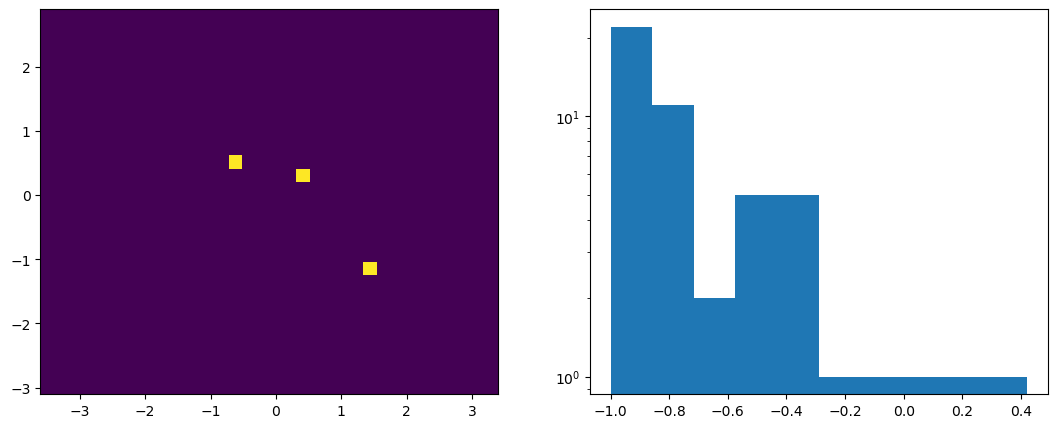

In [16]:
if nbkg>0:
    plt.figure(figsize=(13,5))
    logenergycutoff = 0.0
    plt.subplot(1,2,1)
    plt.hist2d(bkg_samples[:,bkg_samples[0]>logenergycutoff][1,:],
            bkg_samples[:,bkg_samples[0]>logenergycutoff][2,:], 
            bins=[longitudeaxistrue-0.5*(longitudeaxistrue[1]-longitudeaxistrue[0]), latitudeaxistrue-0.5*(latitudeaxistrue[1]-latitudeaxistrue[0])])

    plt.subplot(1,2,2)
    plt.hist(bkg_samples[0,:])
    plt.yscale('log')
    plt.show()

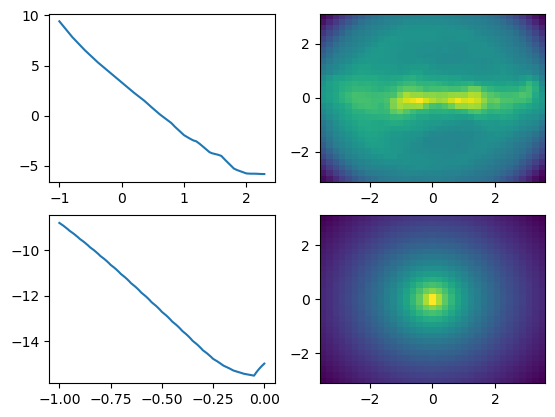

In [17]:

plt.figure()

plt.subplot(221)
plt.plot(log10eaxistrue, bkg_prior((log10eaxistrue,0.0,0.0)))
plt.subplot(222)
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, bkg_prior((*np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij'),))[160,:,:].T)

plt.subplot(223)
plt.plot(log10eaxistrue, logDMpriorfunc(log10eaxistrue,0.0,0.0, 0.0))
plt.subplot(224)
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, logDMpriorfunc(0.0,*np.meshgrid(longitudeaxistrue, latitudeaxistrue), 0.0))
plt.show()

# Likelihood Sampling

In [18]:
testfunc = lambda w, x, y, z: w*z+x*y
disc_like = discrete_loglikelihood(logfunction=testfunc, 
                                   axes=(np.linspace(0,1,100),np.linspace(-1,1,100),), 
                                   dependent_axes=(np.linspace(1,2,100),np.linspace(-1,1,100),))


Number of input dimensions 2
beeeep
Number of data dimensions 2
Axes shape: (100, 100)


In [19]:
testsamples = disc_like.sample((2.0,-1.0), int(1e5))

In [20]:
testsamples.shape

(100000, 2)

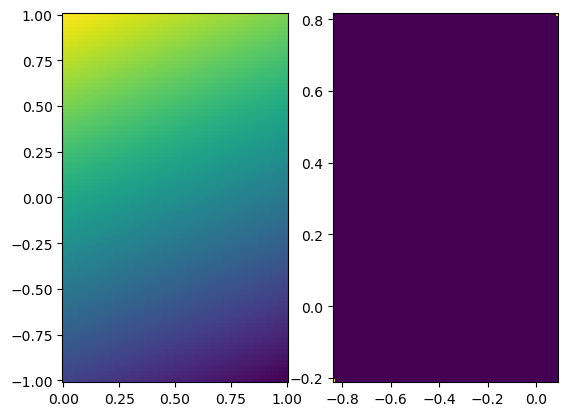

In [21]:
testaxis1, testaxis2 = np.linspace(0,1,100),np.linspace(-1,1,100)

plt.figure()
plt.subplot(121)
plt.pcolormesh(testaxis1, testaxis2, testfunc(*np.meshgrid(testaxis1, testaxis2), 2.0, -1.0,))

plt.subplot(122)
plt.hist2d(testsamples[0], testsamples[1], bins=[100, 100])
plt.show()

## Energy Dispersion

In [22]:
from utils3d import edisp_test, psf_test, log10eaxis, longitudeaxis, latitudeaxis
logjacob_log10e_recon = np.log(10**log10eaxis)
edisp_like = discrete_loglikelihood(logfunction=edisp_test, 
                                    axes=(log10eaxis,), axes_names='log10E recon',
                                    name='energy dispersion',
                                    dependent_axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), logjacob=logjacob_log10e_recon,
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])
edisp_like

Number of input dimensions 1
boop
Axes shape: (171,)


discrete log likelihood class
---------------------------------
name = energy dispersion
logfunction type is <function edisp_test at 0x7f9ca06645e0>
input units of None
over axes log10E recon
with dependent axes ['log10E true', 'lon', 'lat']

In [23]:
sig_log10e_edisp_samples = [edisp_like.sample(signal_event_tuple, 1).tolist() for signal_event_tuple in tqdm(sig_samples.T)]

100%|██████████| 50/50 [00:00<00:00, 1297.56it/s]


In [24]:
signalpriorvals = np.exp(logsumexp(DM_prior((*np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij'),), (truelogmass,))+logenergy_true_logjacob, axis=(1,2)))

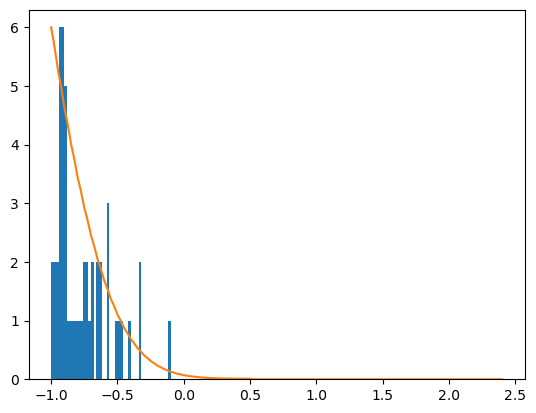

In [25]:
plt.figure()
histvals = plt.hist(np.squeeze(sig_log10e_edisp_samples), bins=log10eaxis)
plt.plot(log10eaxistrue, np.max(histvals[0])*signalpriorvals/np.max(signalpriorvals))
plt.show()

In [26]:
if nbkg>0:
    bkg_log10e_edisp_samples = [edisp_like.sample(event_tuple, 1).tolist() for event_tuple in tqdm(bkg_samples.T)]
else:
    bkg_log10e_edisp_samples = np.array([])

100%|██████████| 50/50 [00:00<00:00, 1535.86it/s]


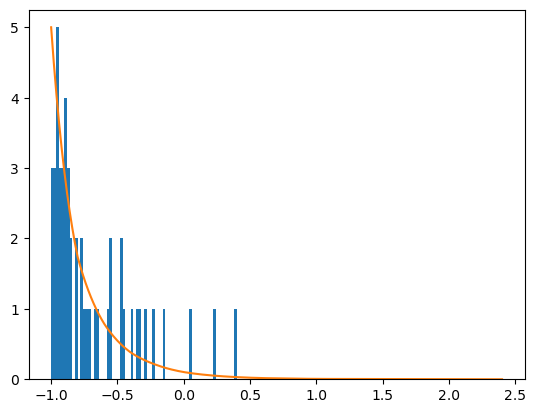

In [27]:

if nbkg>0:
    bkgpriorvals = np.exp(logsumexp(bkg_prior((*np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij'),))+logenergy_true_logjacob, axis=(1,2)))

    plt.figure()
    histvals = plt.hist(np.squeeze(bkg_log10e_edisp_samples), bins=log10eaxis)
    plt.plot(log10eaxistrue, np.max(histvals[0])*bkgpriorvals/np.max(bkgpriorvals))
    plt.show()

## Point spread function

In [28]:
psf_like = discrete_loglikelihood(logfunction=psf_test, 
                                    axes=(longitudeaxis, latitudeaxis), axes_names=['longitude recon', 'latitude recon'],
                                    name='point spread function ',
                                    dependent_axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,),
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])
psf_like

Number of input dimensions 2
beeeep
Number of data dimensions 2
Axes shape: (18, 15)


discrete log likelihood class
---------------------------------
name = point spread function 
logfunction type is <function psf_test at 0x7f9c60444af0>
input units of None
over axes ['longitude recon', 'latitude recon']
with dependent axes ['log10E true', 'lon', 'lat']

In [29]:
psf_like(0.0,0.0,0.0,0.0,0.0)

array([4.70864182])

In [30]:
sig_lonlat_psf_samples =  np.array([list(psf_like.sample(signal_event_tuple, 1) for signal_event_tuple in tqdm(sig_samples.T))]) 


sig_lon_psf_samples = []
sig_lat_psf_samples = []

if nsig>0:
    
    sig_lonlat_psf_samples =  [psf_like.sample(signal_event_tuple, 1).tolist() for signal_event_tuple in tqdm(sig_samples.T)]
    
    for sig_lonlat_psf_sample in sig_lonlat_psf_samples:
        sig_lon_psf_samples.append(sig_lonlat_psf_sample[0])
        sig_lat_psf_samples.append(sig_lonlat_psf_sample[1])

100%|██████████| 50/50 [00:00<00:00, 174.17it/s]


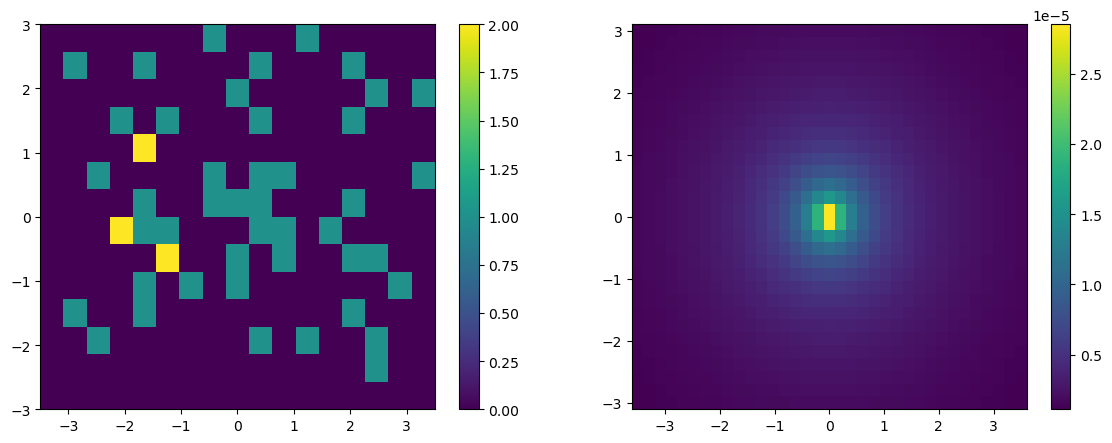

In [31]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.hist2d(sig_lon_psf_samples, sig_lat_psf_samples, bins=[longitudeaxis, latitudeaxis])
plt.colorbar()



plt.subplot(122)
signalpriorvals = np.exp(logsumexp(DM_prior((*np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij'),), (1.0,))+logenergy_true_logjacob, axis=0))
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, signalpriorvals.T)
plt.colorbar()
plt.show()

In [32]:
bkg_lon_psf_samples = []
bkg_lat_psf_samples = []

if nbkg>0:
    
    bkg_lonlat_psf_samples =  [psf_like.sample(event_tuple, 1).tolist() for event_tuple in tqdm(bkg_samples.T)]
    
    for bkg_lonlat_psf_sample in bkg_lonlat_psf_samples:
        bkg_lon_psf_samples.append(bkg_lonlat_psf_sample[0])
        bkg_lat_psf_samples.append(bkg_lonlat_psf_sample[1])
else:
    bkg_lonlat_psf_samples = []
    


100%|██████████| 50/50 [00:00<00:00, 173.22it/s]


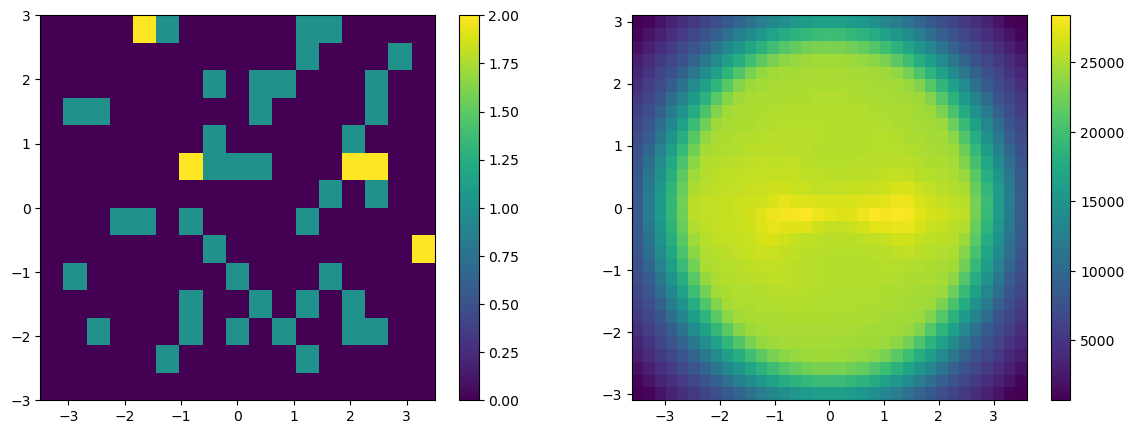

In [33]:
if nbkg>0:
    plt.figure(figsize=(14,5))

    plt.subplot(121)
    plt.hist2d(bkg_lon_psf_samples, bkg_lat_psf_samples, bins=[longitudeaxis, latitudeaxis])
    plt.colorbar()



    plt.subplot(122)
    bkgpriorvals = np.exp(logsumexp(bkg_prior((*np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij'),),)+logenergy_true_logjacob, axis=0))
    plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, bkgpriorvals.T)
    plt.colorbar()
    plt.show()

In [34]:
end = perf_counter()

In [35]:
f'It took {end-start} seconds for {numsamples} events'

'It took 17.452147667000002 seconds for 100 events'

In [36]:
log10e_edisp_samples = np.array(list(sig_log10e_edisp_samples)+list(bkg_log10e_edisp_samples)).flatten()
lon_psf_samples = np.array(list(sig_lon_psf_samples) + list(bkg_lon_psf_samples)).flatten()
lat_psf_samples = np.array(list(sig_lat_psf_samples) + list(bkg_lat_psf_samples)).flatten()

measuredvals = (log10e_edisp_samples, lon_psf_samples, lat_psf_samples)

len(measuredvals)

3

# True Value Marginalisation

In [37]:
import warnings


def marginalise(likelihoods, priors, axisvals=np.array([]), axes=None, dependent_axes=None, hyperparameter_axes=None, logjacob=0):
    
    numpriors = len(priors)
    
    if axes is None:
        axes = likelihoods[0].axes
    if dependent_axes is None:
        dependent_axes = priors[0].axes
        
        
    if hyperparameter_axes is None:
    
        hyperparameter_axes = ((None,) for idx in range(numpriors))
        
        warnings.warn(f'''No hyperparameter values given. \nAssuming axes given by {hyperparameter_axes}''')

    
    num_hyperparameter_axes = len(hyperparameter_axes)


    if numpriors!=num_hyperparameter_axes:
        warnings.warn('''Number of prior objects does not match the number of hyperparameter_axes.
It is presumed that the hyperparameter axes are given in the same order as the respective prior objects.''')
    
    
    prior_logjacob = priors[0].logjacob
    
    dependentaxes_mesh = np.meshgrid(*dependent_axes, indexing='ij')
    priorarrays = []
    for idx in range(numpriors):
        prior = priors[idx]
        single_prior_arrays = []
        if hyperparameter_axes[idx]!=None:
            for hyper_index, hyper_parameter_values in enumerate(np.array(hyperparameter_axes[idx]).T):

                hyper_mesh = []
                
                for hyper_parameter_value in hyper_parameter_values:
                    hyper_mesh.append(dependentaxes_mesh[0]*0+hyper_parameter_value)
                
                single_prior_array = prior.logfunction(*dependentaxes_mesh, *hyper_mesh)
                single_prior_arrays.append(single_prior_array-logsumexp(single_prior_array+logjacob))
        else:
            single_prior_array = prior.logfunction(*dependentaxes_mesh)
            single_prior_arrays = [single_prior_array-logsumexp(single_prior_array+logjacob)]
            print(len(single_prior_arrays))
            
        priorarrays.append(single_prior_arrays)
        
    
    
    
    margvals = []
    for axisval in tqdm(zip(*axisvals)):
        single_measured_log10e, single_measured_lon, single_measured_lat = axisval

        nuisance_logemesh, nuisance_longitudemesh, nuisance_latitudemesh, measured_logemesh, measured_longitudemesh, measured_latitudemesh  = np.meshgrid(log10eaxistrue, 
                                                                                        longitudeaxistrue, latitudeaxistrue, 
                                                                                            single_measured_log10e, single_measured_lon, single_measured_lat, indexing='ij')

        truecoords = np.array([nuisance_longitudemesh.flatten(), nuisance_latitudemesh.flatten()])
        reconcoords = np.array([measured_longitudemesh.flatten(), measured_latitudemesh.flatten()])



        psfvalues = np.squeeze(psf_test(measured_longitudemesh.flatten(), 
                                        measured_latitudemesh.flatten(), 
                                        nuisance_logemesh.flatten(), 
                                        nuisance_longitudemesh.flatten(), 
                                        nuisance_latitudemesh.flatten()).reshape(nuisance_logemesh.shape)) 

        edispvalues = np.squeeze(edisp_test(measured_logemesh,
                                            nuisance_logemesh, 
                                            nuisance_longitudemesh, 
                                            nuisance_latitudemesh).reshape(nuisance_logemesh.shape))


            
        singleevent_margvals = []
        for prior_array_type in priorarrays:
            prior_type_marg_results = []
            for prior_array in prior_array_type:
                output = logsumexp(prior_array+logjacob+psfvalues+edispvalues)#-irfnormalisation)
                prior_type_marg_results.append(output)
                
            if len(prior_type_marg_results)==1:
                prior_type_marg_results = prior_type_marg_results[0]
                singleevent_margvals.append(prior_type_marg_results)
            else:
                singleevent_margvals.append(prior_type_marg_results)
            
        margvals.append(singleevent_margvals)

    fullresult = list(range(numpriors))
    
    firstresult = margvals[0]
    singleevent_result = []
    for idx, singleprior_result in enumerate(firstresult):
        fullresult[idx] = [singleprior_result]
        
    for result in margvals[1:]:
        singleevent_result = []
        for idx, singleprior_result in enumerate(result):
            fullresult[idx] = fullresult[idx]+[singleprior_result]
        
    for idx, result in enumerate(fullresult):
        fullresult[idx] = np.array(result)
    return fullresult

In [38]:
log10masswindowsize = 6/np.sqrt(nsig)
log10masslowerbound = truelogmass-log10masswindowsize
log10massupperbound = truelogmass+log10masswindowsize
if log10masslowerbound<log10eaxistrue[0]:
    log10masslowerbound = log10eaxistrue[0]
if log10massupperbound>2:
    log10massupperbound = 2
log10massaxis = np.linspace(log10masslowerbound,log10massupperbound,51)

marginalised_values = marginalise((edisp_like, psf_like,), (DM_prior, bkg_prior), axisvals=measuredvals,
                                  hyperparameter_axes=((log10massaxis,),None), logjacob=logenergy_true_logjacob)

1


100it [00:35,  2.81it/s]


In [39]:
xiaxis = np.linspace(0,1,100)

In [40]:
marginalised_values[0]

array([[-1.56722698, -1.56940543, -1.57219751, ..., -2.40050223,
        -2.42520095, -2.45024361],
       [-5.555124  , -5.59280199, -5.60461457, ..., -4.77567499,
        -4.77884459, -4.78234238],
       [-5.64981722, -5.6855538 , -5.69595522, ..., -4.87607905,
        -4.87939237, -4.88303768],
       ...,
       [-4.32927981, -4.32595824, -4.32294519, ..., -4.78796082,
        -4.80808108, -4.82860534],
       [-4.30651734, -4.29475589, -4.28402441, ..., -4.30314532,
        -4.31801284, -4.33336284],
       [-3.4472234 , -3.45124708, -3.45568357, ..., -4.38074384,
        -4.40666619, -4.43293246]])

In [41]:
log_hyperparameter_posterior = [np.sum(np.logaddexp(np.log(xival)+np.array(marginalised_values[0]), np.log(1-xival)+np.squeeze(np.array(marginalised_values[1]))[:, np.newaxis]), axis=0) for xival in xiaxis]
# hyperparameter_posterior = [np.sum(np.logaddexp(np.log(xival)+np.array(marginalised_values[:,0]),
#                                                 np.log(1-xival)+np.array(marginalised_values[:,1])), axis=0) for xival in xiaxis]
log_hyperparameter_posterior = log_hyperparameter_posterior - logsumexp(log_hyperparameter_posterior)
hyperparameter_posterior = np.exp(log_hyperparameter_posterior)

(0.0, 0.024456877006338026)

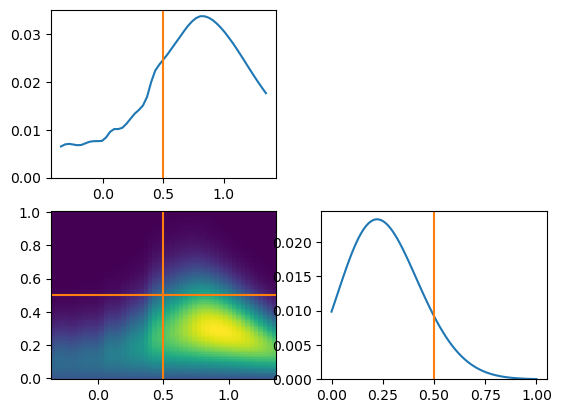

In [42]:
plt.subplot(221)
plt.plot(log10massaxis, np.sum(hyperparameter_posterior, axis=0))
plt.ylim([0,None])
plt.axvline(truelogmass, c='tab:orange')


plt.subplot(223)
plt.pcolormesh(log10massaxis, xiaxis, hyperparameter_posterior)
plt.axhline(signalfraction, c='tab:orange')
plt.axvline(truelogmass, c='tab:orange')

plt.subplot(224)
plt.plot(xiaxis, np.sum(hyperparameter_posterior, axis=1))
plt.axvline(signalfraction, c='tab:orange')
plt.ylim([0,None])


In [43]:

# plt.plot(log10eaxistrue, special.logsumexp(logDMpriorfunc(*inputmesh), axis=(1,2)))

In [44]:
inputmesh = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')
hyperparameter_axes = (*np.meshgrid(np.linspace(-1,1,3), np.logspace(-1,1,3), indexing='ij'),)
hyperparameter_axes = (np.linspace(-1,2.,13),)
flattened_hyperparameter_axes = [hyperparameter_axis.flatten() for hyperparameter_axis in hyperparameter_axes]
flattened_hyperparameter_axes

[array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,
         1.25,  1.5 ,  1.75,  2.  ])]